<a href="https://colab.research.google.com/github/HyeJiJUN11/DataAnalysisProgramming/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#잘못된코드

dfRegularCopy = dfRegular['위반내용'].copy()

idx = 0
for Violation in dfRegularCopy:  
  Violation = str(Violation)
  if '청소년' in Violation:
    if '주류' in Violation:
      dfRegularCopy[idx] = '청소년주류제공'
    else:
      dfRegularCopy[idx] = '청소년관련'

  elif '이물' in Violation:
    dfRegularCopy[idx] = '이물혼입'

  elif '영업장' in Violation:
    dfRegularCopy[idx] = '영업장관련'

  elif '건강진단' in Violation:
    dfRegularCopy[idx] = '건강진단미필'

  elif '위생교육' in Violation:
    dfRegularCopy[idx] = '위생교육미이수'

  elif '노래' in Violation:
    dfRegularCopy[idx] = '일반음식점반주시설'

  else:
    continue
  idx = i+1

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime

In [119]:
#한글폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


# **Project**
202013340 전혜지
## 업종별 분석
*   일반음식점이 다른 업종에 비해 굉장히 많음
*   고로 일반음식점 따로 분석


In [286]:
df = pd.read_csv('/content/서울시 노원구 식품위생업소 행정처분내역 현황.csv', encoding='euc-kr', parse_dates=['처분일자']);
df = df.drop(['교부번호', '소재지지번', '소재지도로명', '지도점검일자', '행정처분상태', '위반일자', '법적근거', '처분내용', '위반내역분류', '처분기간', '운영형태', '외부적발접수일자', '적발기관명(적발기관)', '영업장면적(㎡)', '신고구분'], axis=1)

df['Year'] = df['처분일자'].dt.year 
df = df[(df.Year > 2000) & (df.Year<2021)]
df.tail()


,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year
5630,3100000,2011-07-15,집단급식소식품판매업,집단급식소 식품판매업,(주)선명푸드,과징금 2490 만원 부과,유통기간이 지난 식품을 집단급식소에 판매하기 위하여 운반 및 사용,수시,2011
5631,3100000,2010-11-08,건강기능식품일반판매업,전자상거래(통신판매업),유산균천사,영업정지 1월,질병의 예방 및 치료에 효능 효과가 있거나 의약품으로 오인혼동할 우려가 있는 내용...,수시,2010
5632,3100000,2014-04-25,건강기능식품일반판매업,영업장판매,허브 앤 펫,영업정지,판매사례품 및 경품제공 등 사행심 조장행위 사실과 다르거나 과장된 표시광고행위,수시,2014
5633,3100000,2014-03-24,건강기능식품일반판매업,영업장판매,허브모아,영업정지,사실과 다르거나 과장된 표시광고,기타,2014
5634,3100000,2020-06-25,건강기능식품일반판매업,전자상거래(통신판매업),그레이스 물댄동산(GRACE WATER GARDEN),시정명령,표시해야 할 사항 전부 또는 일부를 표시하지 않는 경우(업체 및 소재지 누락),기타,2020


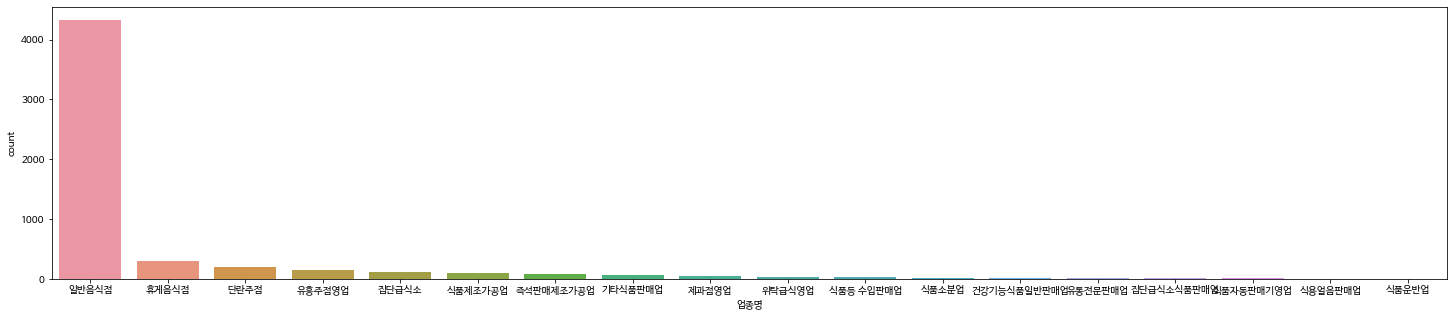

In [309]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='업종명', data = df, order = df['업종명'].value_counts().index)

### 일반음식점 제외

In [267]:
dfDropRegular = df[df.업종명 !='일반음식점']
dfDropRegular.head()

,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year
2185,3100000,2002-05-01,유흥주점영업,간이주점,보스,시정명령(2002.05.15까지),종업원명부미기재,기타,2002
2186,3100000,2010-03-02,유흥주점영업,간이주점,포차 멜로디 노래타운,과태료 20만원 부과,영업자 위생교육 미필,기타,2010
2187,3100000,2004-06-23,유흥주점영업,룸살롱,무랑루즈비즈니스,시정명령,업종 미표시,합동,2004
2188,3100000,2018-01-08,유흥주점영업,룸살롱,마이웨이,시정명령,이물이 혼입된 경우(플라스틱 병뚜껑),수시,2018
2189,3100000,2002-02-01,유흥주점영업,룸살롱,24시유흥주점,영업정지15일(2002.02.05-02.19),유통기한경과제품조리판매목적보관,기타,2002


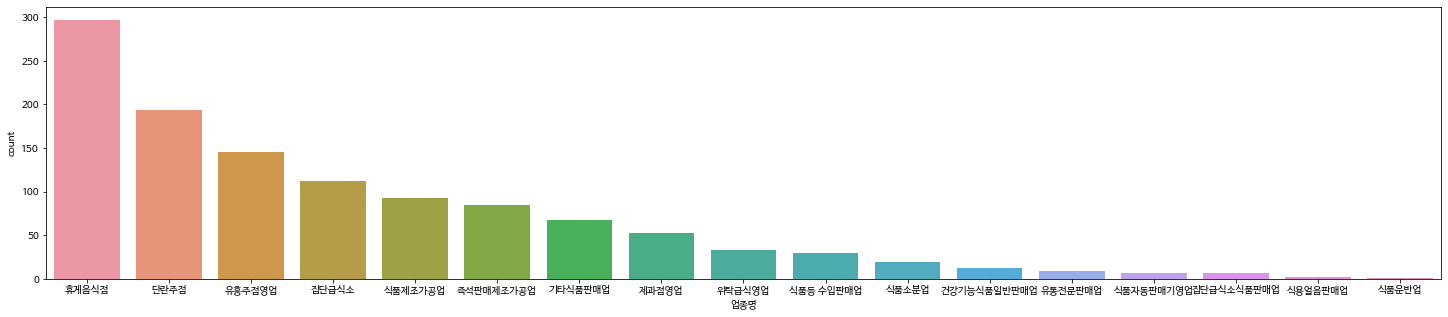

In [287]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='업종명', data = dfDropRegular, order = dfDropRegular['업종명'].value_counts().index)

### 일반음식점

In [310]:
dfRegular = df[df.업종명 =='일반음식점']
dfRegular.head()

,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year
0,3100000,2004-09-14,일반음식점,호프/통닭,원샷,영업정지2월,청소년주류제공1차,기타,2004
1,3100000,2005-09-23,일반음식점,분식,동호,영업정지 7일갈음 과징금 84만원,영업장면적 무단변경,수시,2005
2,3100000,2007-08-20,일반음식점,분식,동호,시정명령,영업장외영업,기타,2007
3,3100000,2007-10-18,일반음식점,분식,동호,과징금부과(56만원),영업장외 영업(탁자),수시,2007
4,3100000,2005-10-24,일반음식점,분식,천궁,시정명령,이물혼입,수시,2005


In [289]:
dfRegular.tail()

,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year
5027,3100000,2019-10-11,일반음식점,호프/통닭,한국통닭(석계점),시정명령,영업장외 영업,기타,2019
5029,3100000,2019-11-04,일반음식점,중국식,라공방 노원점,과태료40만원(영업자30만원종업원10만원)부과,건강진단을 받지 않은 종업원,기타,2019
5030,3100000,2019-11-04,일반음식점,중국식,라공방 노원점,과태료40만원(영업자30만원종업원10만원)부과,건강진단을 받지 않은 자를 영업에 종사시킨 영업자,기타,2019
5031,3100000,2020-02-10,일반음식점,호프/통닭,1943노원점,영업정지,청소년에게 주류를 제공하는 행위,기타,2020
5032,3100000,2020-12-30,일반음식점,호프/통닭,남남북녀라이브,영업정지,손님이 노래를 부르도록 허용 행위(자막용 영상장치 및 자동반주장치 설치),수시,2020


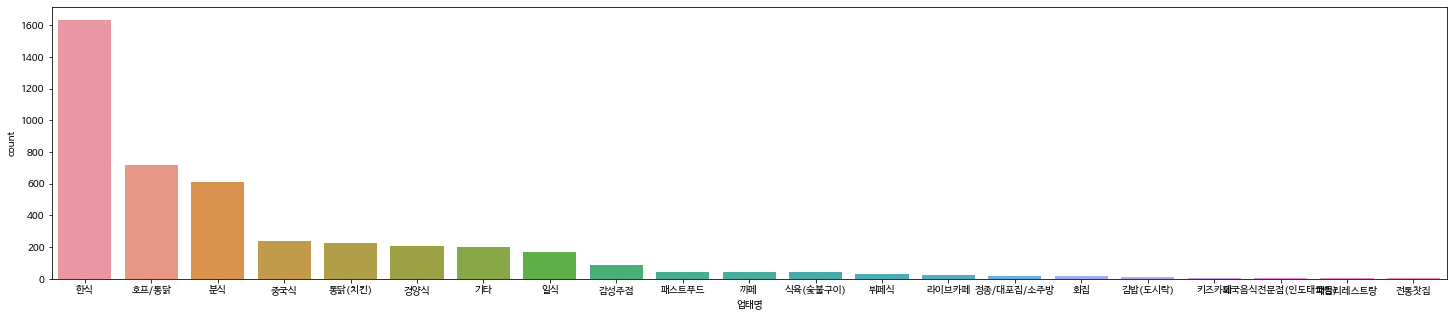

In [290]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='업태명', data = dfRegular, order = dfRegular['업태명'].value_counts().index)

In [319]:
def replace(x) :
  x = str(x)
  if '청소년' in x:
    s = '청소년 주류 제공'

  elif '이물' in x:
    s = '이물혼입'

  elif '영업장' in x:
    s = '영업장관련'

  elif '건강진단' in x:
    s = '건강진단 미필'

  elif '위생교육' in x:
    s = '위생교육 미이수'

  elif '노래' in x:
    s = '반주시설'

  elif '위생' in x or '청결' in x:
    s = '위생 불량'
  
  elif '유흥' in x or '접객' in x:
    s = '유흥접객 행위'
    
  elif '유통기한' in x :
    s = '유통기한'

  elif '가격표' in x :
    s = '가격표 표시 누락'
  
  elif '체납' in x :
    s = '세금 체납'

  elif '변경신고' in x:
    s = '변경신고 없이 시설변경'
  
  elif '말소' in x:
    s = '사업자등록 말소'
  
  elif '원산지' in x:
    s = '원산지 미표기'
  else:
    s = '기타'

  return str(s)

dfRegularCopy = dfRegular['위반내용'].copy()
dfRegularCopy = dfRegularCopy.apply(replace)
dfRegular['위반내용수정'] = dfRegularCopy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [320]:
def replace2(x) :
  x = str(x)
  if '영업정지' in x:
    s = '영업정지'

  elif '과징금' in x:
    s = '과징금'

  elif '과태료' in x:
    s = '과태료'

  elif '시정명령' in x:
    s = '시정명령'

  elif '영업소폐쇄' in x:
    s = '영업소폐쇄'

  else:
    s = '기타'

  return str(s)

dfRegularCopy = dfRegular['처분명'].copy()
dfRegularCopy = dfRegularCopy.apply(replace2)
dfRegular['처분명수정'] = dfRegularCopy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [321]:
dfRegular.head()

,시군구코드,처분일자,업종명,업태명,업소명,처분명,위반내용,적발구분,Year,처분명수정,위반내용수정
0,3100000,2004-09-14,일반음식점,호프/통닭,원샷,영업정지2월,청소년주류제공1차,기타,2004,영업정지,청소년 주류 제공
1,3100000,2005-09-23,일반음식점,분식,동호,영업정지 7일갈음 과징금 84만원,영업장면적 무단변경,수시,2005,영업정지,영업장관련
2,3100000,2007-08-20,일반음식점,분식,동호,시정명령,영업장외영업,기타,2007,시정명령,영업장관련
3,3100000,2007-10-18,일반음식점,분식,동호,과징금부과(56만원),영업장외 영업(탁자),수시,2007,과징금,영업장관련
4,3100000,2005-10-24,일반음식점,분식,천궁,시정명령,이물혼입,수시,2005,시정명령,이물혼입


In [ ]:
for Violation in dfRegular['위반내용수정']: 
  print(Violation)

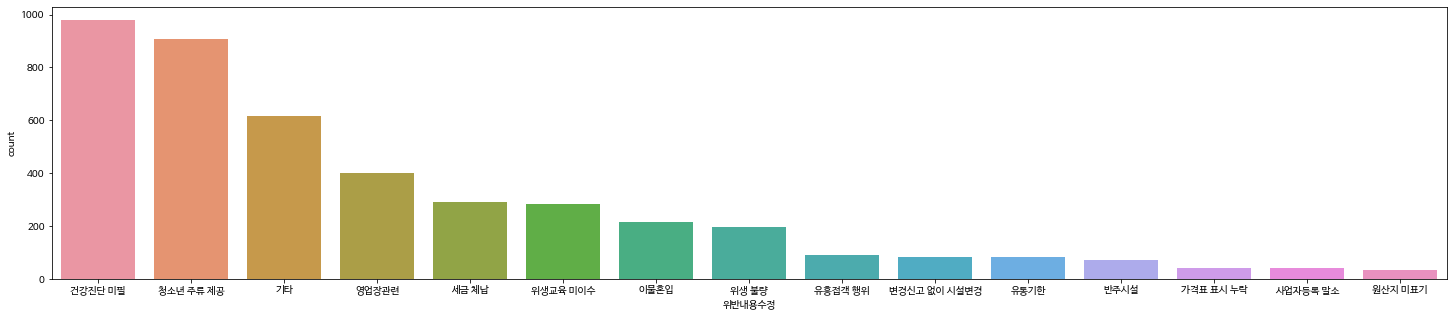

In [322]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='위반내용수정', data = dfRegular, order = dfRegular['위반내용수정'].value_counts().index)

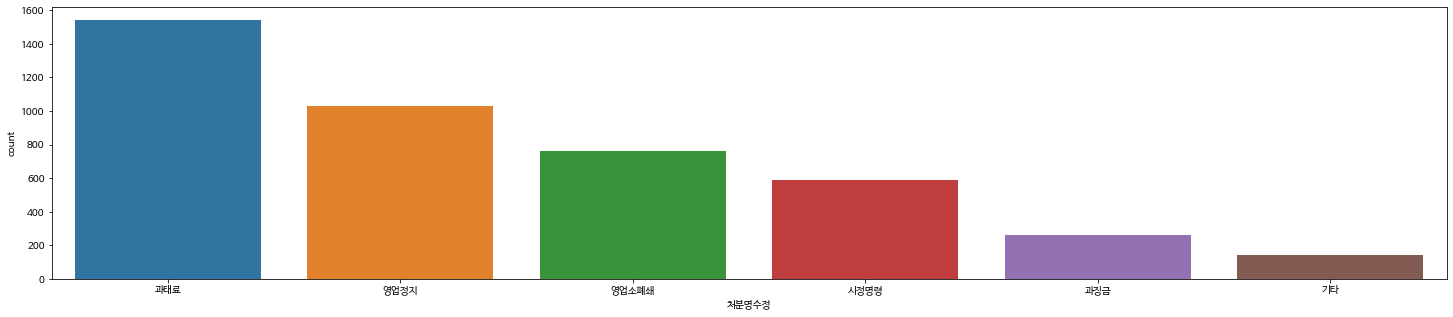

In [323]:
plt.rcParams["figure.figsize"] = (25, 5)
fig = sns.countplot(x ='처분명수정', data = dfRegular, order = dfRegular['처분명수정'].value_counts().index)

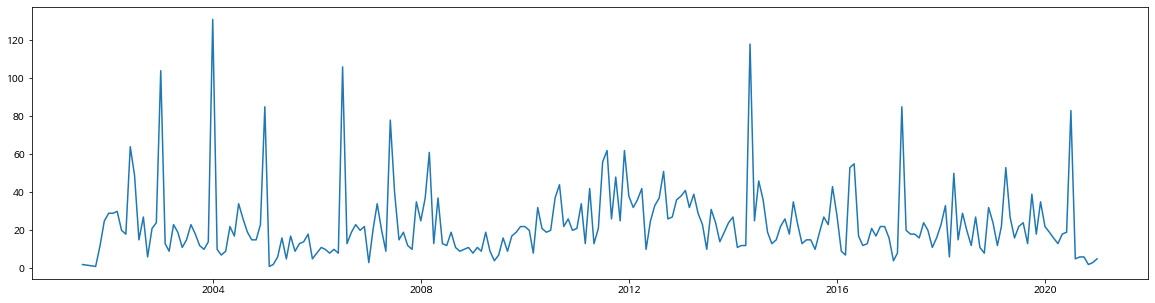

In [325]:
data_dates = df['처분일자'].value_counts()
dates = data_dates.to_frame(name='위반횟수')
dates.index.name = '처분일자'
dates.sort_values(by=['처분일자'])

dates = dates.resample('M').sum()
dates = dates[dates.위반횟수 != 0]
#dates = dates.sort_values(by='위반횟수', ascending=False)

plt.figure(figsize=(20, 5))
plt.plot(dates.index, dates.위반횟수)